In [8]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Date    : 2016-10-19 09:40:52
# @Author  : Zhao Yong
%matplotlib inline
import numpy as np
import scipy.io as scio  
import pandas as pd
from datetime import datetime


dataFile = 'inputDataOHLCDaily_20120511.mat'  
data = scio.loadmat(dataFile)
temp = data['syms'][0]==u'TU'
p = temp.tolist().index(True)
tday = data['tday'][:,p].astype(int).astype(str)   # 转str
cl = data['cl'][:,p]
## tday, cl 转为series
clseries = pd.Series(index=tday, data=cl)

lookback=250;
holddays=25;
## 过去250天收益为正，做多；为负，做空
longs_log = clseries > clseries.shift(lookback)
shorts_log = clseries < clseries.shift(lookback)
## logical转int
longs = longs_log.astype(int)
shorts = shorts_log.astype(int)

pos = np.zeros(len(cl))

for h in range(holddays):
    long_lag = longs.shift(h)
    long_lag[np.isnan(long_lag)] = False
    long_lag = long_lag.astype(bool)
    
    short_lag = shorts.shift(h)
    short_lag[np.isnan(short_lag)] = False
    short_lag = short_lag.astype(bool)
    
    pos[long_lag.values] = pos[long_lag.values] + 1
    pos[short_lag.values] = pos[short_lag.values] - 1
position = pd.Series(index=tday, data=pos,dtype=int)
ret = position.shift(1)*clseries.pct_change()/holddays
ret = ret.fillna(0)

In [9]:
## 计算指标
def MaxDD(cumret):
    ### 计算最大回撤
    highwatermark=np.zeros(len(cumret))
    drawdown=np.zeros(len(cumret))
    drawdownduration=np.zeros(len(cumret))
    
    for t in range(1,len(cumret)):
        highwatermark[t] = max(highwatermark[t-1], cumret[t])
        drawdown[t] = (1+cumret[t])/(1+highwatermark[t])-1  # drawdown on each day
        if drawdown[t] == 0:
            drawdownduration[t] = 0
        else:
            drawdownduration[t] = drawdownduration[t-1]+1
    maxDD=min(drawdown) # maximum drawdown

    maxDDD=int(max(drawdownduration)) # maximum drawdown duration
    return maxDD, maxDDD, drawdown
def stratanalyz(ret):
    ### 转换时间戳, 
    ##  TODO: 判断时间格式
    tdate = map(lambda x:datetime.strptime(x, '%Y%m%d').date(), ret.index)
    cumret = (1+ret).cumprod()-1
    APR = np.prod(1+ret)**(252./len(ret))-1
    Avg_Ann_Ret = 252*ret.mean()
    Ann_Volatility = np.sqrt(252)*ret.std()
    Sharpe_ratio = np.sqrt(252)*ret.mean()/ret.std()
    [maxDD,maxDDD,_]=MaxDD(cumret)
    Winrate = float(sum(ret > 0))/len(ret)

    pf = dict((['APR', format(APR,'.4%')], 
                        ['Avg_Ann_Ret', format(Avg_Ann_Ret,'.4%')],
                        ['Ann_Volatility', format(Ann_Volatility,'.4%')],
                        ['Winrate', format(Winrate,'.4%')],
                        ['Sharpe_ratio', Sharpe_ratio],
                        ['maxDD', maxDD],
                        ['maxDDD', maxDDD]))
    performance = pd.DataFrame.from_dict(pf, orient="index")
    performance = performance.rename(columns={0: 'Performance'})
    return performance

In [10]:
stratanalyz(ret)

,Performance
APR,1.6708%
maxDD,-0.0248475
Winrate,44.5000%
Ann_Volatility,1.6038%
Sharpe_ratio,1.0412
Avg_Ann_Ret,1.6699%
maxDDD,343


In [19]:
def ploter(price, ret):
    import matplotlib
    name = matplotlib.matplotlib_fname()
    from matplotlib.font_manager import FontProperties
    font = FontProperties(fname = name)
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_style('whitegrid')

    
    tdate = map(lambda x:datetime.strptime(x, '%Y%m%d').date(), ret.index)
    cumret = (1+ret).cumprod()-1
    
    Fig = plt.figure(figsize=(20,10))
    pcumret = plt.subplot(3,1,1)
    pcumret.plot(tdate, cumret.values, label='Cumret', color='b', )
    pcumret.legend(loc=2)
    pcumret.set_ylabel('Cumret', fontsize=16)
    pcumret.set_title(u'Blue is Cumret, red is Price',fontsize=16)
    pprice=plt.twinx()    

    ###创建公用的y坐标轴
    pprice.plot(tdate,price, label='Price',color='r')
    pprice.legend(loc=0)
    pprice.set_ylabel('Price', fontsize=16)

    ### 最大回撤
    pDD = plt.subplot(3, 1, 2)
    pDD.set_ylabel("Drawdown", fontsize=16)
    drawdownList = MaxDD(cumret)[2]
    pDD.fill_between(tdate, drawdownList, color='g')
    pDD.set_title(u'Drawdown',fontsize=16)
    pdown = plt.twinx()
    pdown.plot(tdate, cumret.values, label='Cumret', color='b', )
    pdown.legend(loc=2)
    pdown.set_ylabel('Cumret', fontsize=16)

    ### 每笔收益
    pPnl = plt.subplot(3, 1, 3)
    pPnl.set_ylabel("Pnl",fontsize=16)
    pPnl.bar(tdate, ret, width=3.5 ,color='b')
    pPnl.set_title(u'PnL',fontsize=16)
    plt.show()
    plt.savefig('Record.png')

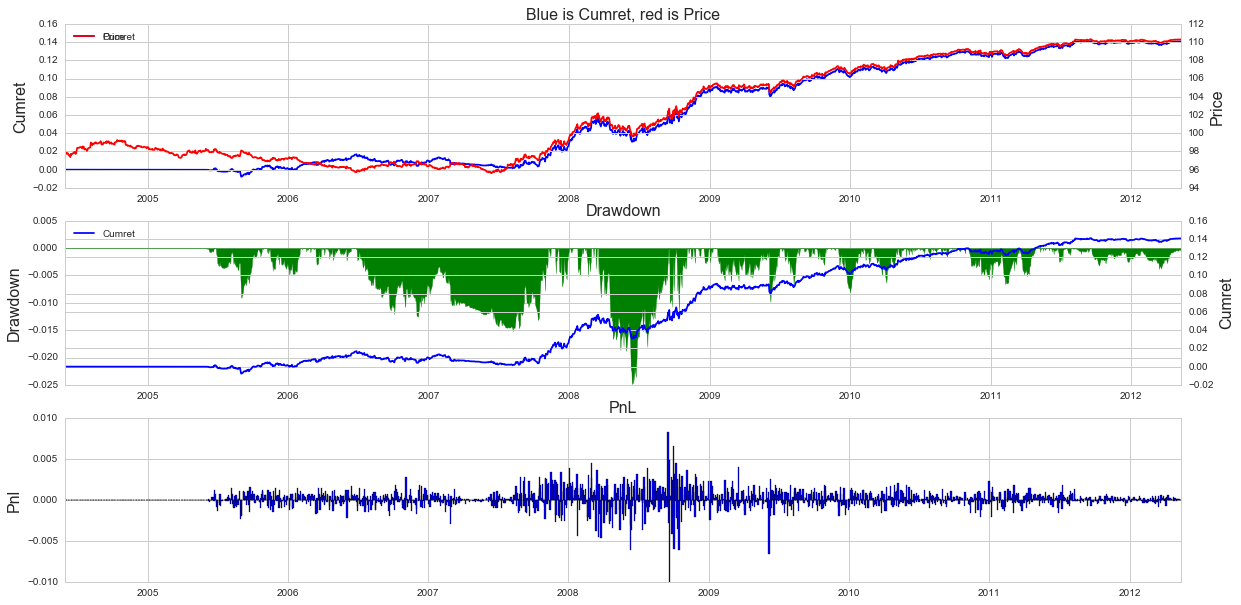

In [20]:
ploter(cl,ret)